<a href="https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [ ]:
#!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html!

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html!
  Using cached jax-0.4.26-py3-none-any.whl (1.9 MB)
INFO: pip is looking at multiple versions of jax[cuda12-pip] to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.4.25-py3-none-any.whl (1.8 MB)
  Using cached jax-0.4.24-py3-none-any.whl (1.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.3.25
    Uninstalling jax-0.3.25:
      Successfully uninstalled jax-0.3.25
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dalle-mini 0.1.5 requires jax==0.3.25, but you have jax 0.4.23 which is incompatible.


In [ ]:

!pip install "jax[cpu]==0.3.25" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Using cached jax-0.3.25-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26
    Uninstalling jaxlib-0.4.26:
      Successfully uninstalled jaxlib-0.4.26
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26


In [ ]:
# prompt: !pip install jaxlib version that is compitable with jax version 0.3.25

#!pip install jaxlib==0.4.6


  Using cached jaxlib-0.4.6-cp310-cp310-manylinux2014_x86_64.whl (62.0 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26
    Uninstalling jaxlib-0.4.26:
      Successfully uninstalled jaxlib-0.4.26


In [ ]:
# prompt: ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# dalle-mini 0.1.5 requires jax==0.3.25, but you have jax 0.4.26 which is incompatible.
# Successfully installed jax-0.4.26

#!pip install jax==0.3.25
#!pip install orbax-checkpoint==0.1.1 jax==0.3.25

In [ ]:
# Required only for colab environments + GPU
#!pip install jax==0.3.25 jaxlib==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

  Preparing metadata (setup.py) ... done


In [ ]:
import jax
print(jax.devices())

[CpuDevice(id=0)]


In [ ]:
# prompt: ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# orbax-checkpoint 0.4.4 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.

!pip install --upgrade jax


  Using cached jax-0.4.26-py3-none-any.whl (1.9 MB)
  Attempting uninstall: jax
    Found existing installation: jax 0.3.25
    Uninstalling jax-0.3.25:
      Successfully uninstalled jax-0.3.25
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dalle-mini 0.1.5 requires jax==0.3.25, but you have jax 0.4.26 which is incompatible.


We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:49.3
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmpyek1nsxn:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('m

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/304M [00:00<?, ?B/s]

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial


# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:40.8


enwiki-words-frequency.txt:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Let's define some text prompts.

In [ ]:
prompts = [
    "Zoomout Canine dog hip joint x-ray image, centered placement, with a date displayed on the top right with left angle 103.83 degrees and right angle 117.92 degrees",
    "Centralized Specific view of a dog canine's hip x-ray, presenting well-defined hip joints and accompanied by a date with left angle 117.1 degrees and right angle 86.43 degrees",
    "Centralized Canine hip x-ray image with a focused view on the hip region, showcasing prominent bone structure and featuring a date in the upper right corner with left angle 115.35 degrees and right angle 111.55 degrees",
    "Centralized X-ray image centered on the hip region of a dog, highlighting the symmetry of the joints and featuring a date for reference with left angle 115.75 degrees and right angle 85.64 degrees",
    "Centralized Detailed radiograph highlighting the hip joint of a dog, with an evident difference in joint elevation and a date for documentation with left angle 96.81 degrees and right angle 81.54 degrees"

]

Note: we could use the same prompt multiple times for faster inference.

In [ ]:
tokenized_prompts = processor(prompts)

Finally we replicate the prompts onto each device.

In [ ]:
tokenized_prompt = replicate(tokenized_prompts)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [ ]:
# number of predictions per prompt
n_predictions = 2

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

Prompts: ['Zoomout Canine dog hip joint x-ray image, centered placement, with a date displayed on the top right with left angle 103.83 degrees and right angle 117.92 degrees', "Centralized Specific view of a dog canine's hip x-ray, presenting well-defined hip joints and accompanied by a date with left angle 117.1 degrees and right angle 86.43 degrees", 'Centralized Canine hip x-ray image with a focused view on the hip region, showcasing prominent bone structure and featuring a date in the upper right corner with left angle 115.35 degrees and right angle 111.55 degrees', 'Centralized X-ray image centered on the hip region of a dog, highlighting the symmetry of the joints and featuring a date for reference with left angle 115.75 degrees and right angle 85.64 degrees', 'Centralized Detailed radiograph highlighting the hip joint of a dog, with an evident difference in joint elevation and a date for documentation with left angle 96.81 degrees and right angle 81.54 degrees']



  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


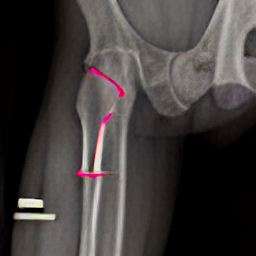

Saved image_0.png



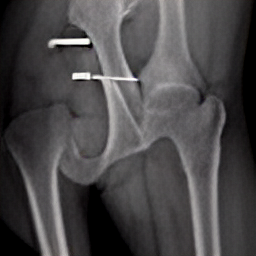

Saved image_1.png



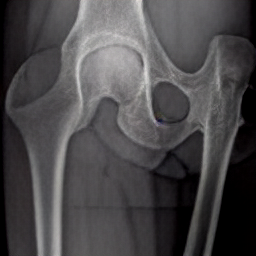

Saved image_2.png



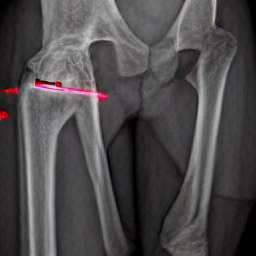

Saved image_3.png



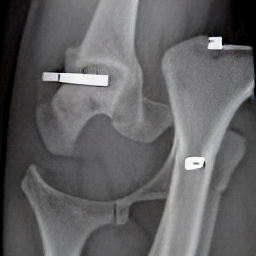

Saved image_4.png



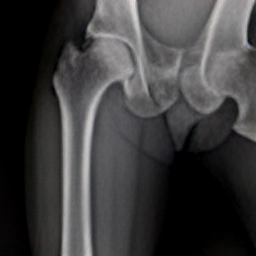

Saved image_0.png



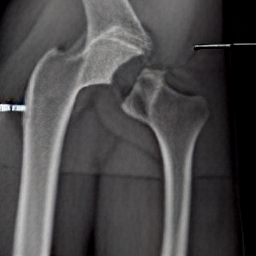

Saved image_1.png



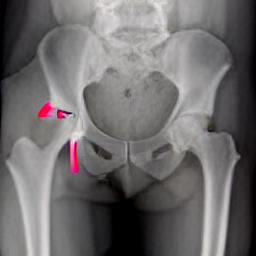

Saved image_2.png



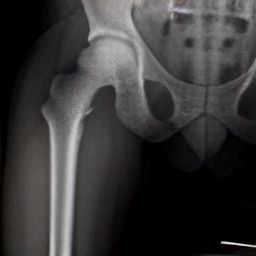

Saved image_3.png



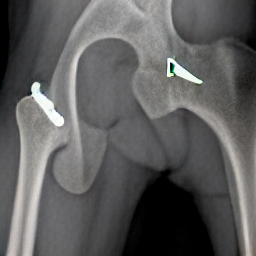

Saved image_4.png



In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
import os


print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    # Ensure the directory exists
    os.makedirs('generated_images', exist_ok=True)

    for i, decoded_img in enumerate(decoded_images):
      img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
      images.append(img)
      # Save the image
      img.save(f'generated_images/image_{i}.png')
      display(img)
      print(f'Saved image_{i}.png')
      print()

In [ ]:
!nvidia-smi

Mon Apr  8 01:56:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              46W / 300W |  14584MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🏅 Optional: Rank images by CLIP score

We can rank images according to CLIP.

**Note: your session may crash if you don't have a subscription to Colab Pro.**

In [ ]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)


# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [ ]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=prompts * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

# organize scores per prompt
p = len(prompts)
logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()

Let's now display images ranked by CLIP score.

In [ ]:
for i, prompt in enumerate(prompts):
    print(f"Prompt: {prompt}\n")
    for idx in logits[i].argsort()[::-1]:
        display(images[idx * p + i])
        print(f"Score: {jnp.asarray(logits[i][idx], dtype=jnp.float32):.2f}\n")
    print()

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [ ]:
import wandb

# Initialize a W&B run.
project = "dalle-mini-tables-colab"
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    if logits is not None:
        idxs = logits[i].argsort()[::-1]
        tmp_imgs = images[i :: len(prompts)]
        tmp_imgs = [tmp_imgs[idx] for idx in idxs]
    else:
        tmp_imgs = images[i :: len(prompts)]

    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for img in tmp_imgs])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

Click on the link above to check out your generated images.